In [96]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

#### Load dataset

In [97]:
# create dataframe from file
df = pd.read_csv("university_data.csv")
print(df.shape)
df.head()

(1327, 8)


,Name,Applicants total,Admissions total,Enrolled total,Tuition and fees,Costs of living on campus,Ranking,Ranking display
0,Alabama A & M University,6142.0,5521.0,1104.0,7182.0,27441.0,1000+,1000+
1,University of Alabama at Birmingham,5689.0,4934.0,1773.0,7206.0,31687.0,301-400,top 1000
2,University of Alabama in Huntsville,2054.0,1656.0,651.0,9192.0,35780.0,1000+,1000+
3,Alabama State University,10245.0,5251.0,1479.0,8720.0,25222.0,1000+,1000+
4,The University of Alabama,30975.0,17515.0,6454.0,9450.0,41500.0,1000+,1000+


#### Add Enrolled and Admissions [%]

In [98]:
# Add % split of enrolled/applicants and admissions/applicants
df["Enrolled percentage"] = round(df["Enrolled total"] / df["Applicants total"] * 100, 2)
df["Admission percentage"] = round(df["Admissions total"] / df["Applicants total"] * 100, 2)
df = df.drop(columns=['Enrolled total', 'Applicants total', 'Admissions total'])
enrolledPercentageColumn = df.pop('Enrolled percentage')
admissionPercentageColumn = df.pop('Admission percentage')
df.insert(1, 'Enrolled percentage', enrolledPercentageColumn)
df.insert(1, 'Admission percentage', admissionPercentageColumn)
df.head()

,Name,Admission percentage,Enrolled percentage,Tuition and fees,Costs of living on campus,Ranking,Ranking display
0,Alabama A & M University,89.89,17.97,7182.0,27441.0,1000+,1000+
1,University of Alabama at Birmingham,86.73,31.17,7206.0,31687.0,301-400,top 1000
2,University of Alabama in Huntsville,80.62,31.69,9192.0,35780.0,1000+,1000+
3,Alabama State University,51.25,14.44,8720.0,25222.0,1000+,1000+
4,The University of Alabama,56.55,20.84,9450.0,41500.0,1000+,1000+


In [99]:
def modifyRanking(ranking):
    if '-' in ranking:
        ranking = (int(ranking.split('-')[0]) + int(ranking.split('-')[1])) // 2
    elif '+' in ranking:
        ranking = ranking[:len(ranking)-1]
    return ranking

### Correlation Matrix for top 1000 universities

In [100]:
topUniDf = df[df['Ranking display'] == 'top 1000'].drop(columns=['Name', 'Ranking display'])
topUniDf['Ranking'] = df.apply(lambda row: modifyRanking(row['Ranking']), axis=1)
topUniDf['Ranking'] = pd.to_numeric(topUniDf['Ranking'])

corrMatrixTopUni = topUniDf.corr(method='pearson')
corrMatrixTopUni.style.background_gradient(cmap='coolwarm')

,Admission percentage,Enrolled percentage,Tuition and fees,Costs of living on campus,Ranking
Admission percentage,1.000000,0.797229,-0.685872,-0.732538,0.449003
Enrolled percentage,0.797229,1.000000,-0.702318,-0.784953,0.409591
Tuition and fees,-0.685872,-0.702318,1.000000,0.891072,-0.239200
Costs of living on campus,-0.732538,-0.784953,0.891072,1.000000,-0.405386
Ranking,0.449003,0.409591,-0.239200,-0.405386,1.000000


### Correlation Matrix for universities ranked 1000+

In [101]:
nonTopUniDf = df[df['Ranking display'] == '1000+'].drop(columns=['Name', 'Ranking', 'Ranking display'])

corrMatrixNonTopUni = nonTopUniDf.corr(method='pearson')
corrMatrixNonTopUni.style.background_gradient(cmap='coolwarm')

,Admission percentage,Enrolled percentage,Tuition and fees,Costs of living on campus
Admission percentage,1.000000,0.539891,-0.155404,-0.170942
Enrolled percentage,0.539891,1.000000,-0.456628,-0.477992
Tuition and fees,-0.155404,-0.456628,1.000000,0.876088
Costs of living on campus,-0.170942,-0.477992,0.876088,1.000000


### Correlation Matrix for all universities

In [102]:
allUniWithRankDf = df.drop(columns=['Name','Ranking display'])

allUniWithRankDf['Ranking'] = df.apply(lambda row: modifyRanking(row['Ranking']), axis=1)
allUniWithRankDf['Ranking'] = pd.to_numeric(allUniWithRankDf['Ranking'])

corrMatrixAllUniWithRank = allUniWithRankDf.corr(method='pearson')
corrMatrixAllUniWithRank.style.background_gradient(cmap='coolwarm')

,Admission percentage,Enrolled percentage,Tuition and fees,Costs of living on campus,Ranking
Admission percentage,1.000000,0.571214,-0.244913,-0.293421,0.282055
Enrolled percentage,0.571214,1.000000,-0.483443,-0.513984,0.128868
Tuition and fees,-0.244913,-0.483443,1.000000,0.855667,-0.047608
Costs of living on campus,-0.293421,-0.513984,0.855667,1.000000,-0.261328
Ranking,0.282055,0.128868,-0.047608,-0.261328,1.000000


#### Outlier detection

In [103]:
anomalyDetectionDf = df.drop(columns=['Name', 'Ranking', 'Ranking display'])
print(anomalyDetectionDf.shape)
scaler = MinMaxScaler()
normalizedData = scaler.fit_transform(anomalyDetectionDf)
normalizedData

(1327, 4)


array([[0.89280034, 0.18488461, 0.07357357, 0.29936555],
       [0.85929382, 0.35226985, 0.07410352, 0.37859675],
       [0.79450748, 0.35886381, 0.11795619, 0.45497294],
       ...,
       [0.40631958, 0.18006594, 0.04349938, 0.36738197],
       [0.69409395, 0.01014456, 0.60612083, 0.69637992],
       [0.50461245, 0.1648491 , 0.44983219, 0.50763202]])

n_neighbors = 8


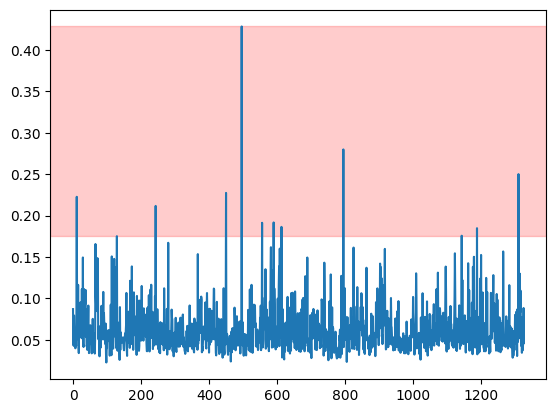

In [104]:
threshold = 0.175
n_neighbors = math.ceil(math.log(anomalyDetectionDf.shape[0]))

print(f'n_neighbors = {n_neighbors}')

neigh = NearestNeighbors(n_neighbors=n_neighbors)
neigh.fit(normalizedData)

distances, indices = neigh.kneighbors(normalizedData)
anomalyDetectionDf['distance'] = distances.mean(axis=1)
anomalyDetectionDf.head()

ax = plt.subplot()
ax.plot(anomalyDetectionDf['distance'])
ax.axhspan(threshold, max(anomalyDetectionDf['distance']), alpha=0.2, color='red')

In [105]:
outliersDf = anomalyDetectionDf[anomalyDetectionDf['distance'] > threshold]
outliersIndices = outliersDf.index.tolist() # powinno wyjść ok. 1% (13) / 5% (66) / 10% (130)
df['Outlier'] = False
df.loc[outliersIndices, 'Outlier'] = True
df[df['Outlier'] == True]['Ranking'].value_counts()

Ranking
1000+    12
Name: count, dtype: int64

In [106]:
# Correlation Matrix for outliers

outliersForCmDf = df[df['Outlier'] == True].drop(columns=['Name', 'Ranking', 'Ranking display', 'Outlier'])
corrMatrixOutliers = outliersForCmDf.corr(method='pearson')
corrMatrixOutliers.style.background_gradient(cmap='coolwarm')

,Admission percentage,Enrolled percentage,Tuition and fees,Costs of living on campus
Admission percentage,1.000000,0.671812,0.083843,0.130671
Enrolled percentage,0.671812,1.000000,0.059696,0.127754
Tuition and fees,0.083843,0.059696,1.000000,0.977685
Costs of living on campus,0.130671,0.127754,0.977685,1.000000


In [107]:
# Correlation Matrix for non outliers

nonOutliersForCmDf = df[df['Outlier'] == False].drop(columns=['Name', 'Ranking', 'Ranking display', 'Outlier'])
corrMatrixNonOutliers = nonOutliersForCmDf.corr(method='pearson')
corrMatrixNonOutliers.style.background_gradient(cmap='coolwarm')

,Admission percentage,Enrolled percentage,Tuition and fees,Costs of living on campus
Admission percentage,1.000000,0.568097,-0.252878,-0.302719
Enrolled percentage,0.568097,1.000000,-0.514309,-0.541791
Tuition and fees,-0.252878,-0.514309,1.000000,0.855465
Costs of living on campus,-0.302719,-0.541791,0.855465,1.000000


In [108]:
dfAll = df.copy() # All universities
df = df[df['Outlier'] == False].drop(columns=['Outlier']) # Universities without outliers
df.head()

,Name,Admission percentage,Enrolled percentage,Tuition and fees,Costs of living on campus,Ranking,Ranking display
0,Alabama A & M University,89.89,17.97,7182.0,27441.0,1000+,1000+
1,University of Alabama at Birmingham,86.73,31.17,7206.0,31687.0,301-400,top 1000
2,University of Alabama in Huntsville,80.62,31.69,9192.0,35780.0,1000+,1000+
3,Alabama State University,51.25,14.44,8720.0,25222.0,1000+,1000+
4,The University of Alabama,56.55,20.84,9450.0,41500.0,1000+,1000+


#### Clustering

In [109]:
clusteringDf = df.drop(columns=['Name', 'Ranking', 'Ranking display'])
clusteringDf.head()

,Admission percentage,Enrolled percentage,Tuition and fees,Costs of living on campus
0,89.89,17.97,7182.0,27441.0
1,86.73,31.17,7206.0,31687.0
2,80.62,31.69,9192.0,35780.0
3,51.25,14.44,8720.0,25222.0
4,56.55,20.84,9450.0,41500.0


In [110]:
scaler = MinMaxScaler()
normalizedData = scaler.fit_transform(clusteringDf)
clusteringDf = pd.DataFrame(normalizedData, columns=clusteringDf.columns)
clusteringDf.head()

,Admission percentage,Enrolled percentage,Tuition and fees,Costs of living on campus
0,0.892800,0.210450,0.063064,0.235295
1,0.859294,0.400982,0.063600,0.321772
2,0.794507,0.408487,0.107950,0.405132
3,0.483088,0.159498,0.097410,0.190102
4,0.539285,0.251876,0.113711,0.521629


In [111]:
kmeans = KMeans(n_clusters=5)
df['Cluster'] = kmeans.fit_predict(clusteringDf)

c:\Users\michu\source\repos\american-universities-eda\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


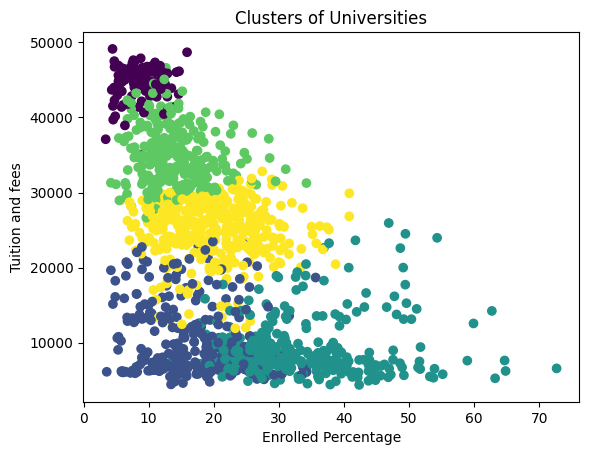

In [112]:
plt.scatter(df['Enrolled percentage'], df['Tuition and fees'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Enrolled Percentage')
plt.ylabel('Tuition and fees')
plt.title('Clusters of Universities')
plt.show()

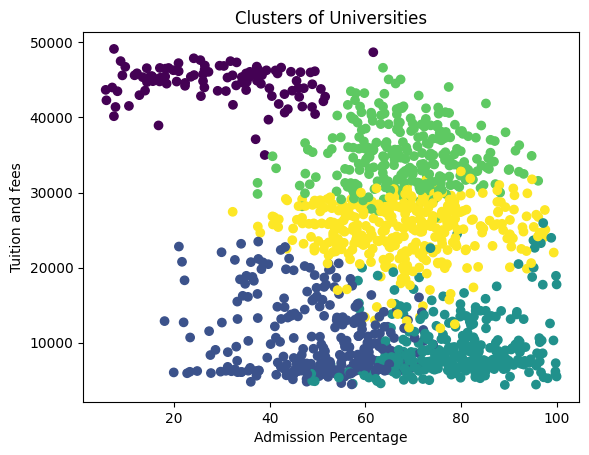

In [113]:
plt.scatter(df['Admission percentage'], df['Tuition and fees'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Admission Percentage')
plt.ylabel('Tuition and fees')
plt.title('Clusters of Universities')
plt.show()

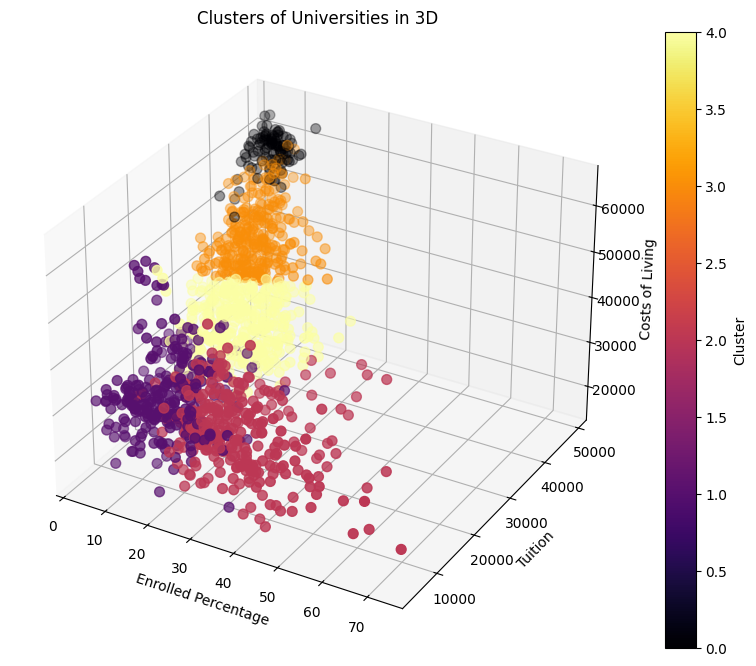

In [114]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['Enrolled percentage'],
    df['Tuition and fees'],
    df['Costs of living on campus'],
    c=df['Cluster'],
    cmap='inferno',
    s=50
)

ax.set_xlabel('Enrolled Percentage')
ax.set_ylabel('Tuition')
ax.set_zlabel('Costs of Living')
ax.set_title('Clusters of Universities in 3D')

colorbar = fig.colorbar(scatter, ax=ax)
colorbar.set_label('Cluster')

plt.show()

In [115]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['Admission percentage'],
    df['Tuition and fees'],
    df['Costs of living on campus'],
    c=df['Cluster'],
    cmap='inferno',
    s=50
)

ax.set_xlabel('Admission Percentage')
ax.set_ylabel('Tuition')
ax.set_zlabel('Costs of Living')
ax.set_title('Clusters of Universities in 3D')

colorbar = fig.colorbar(scatter, ax=ax)
colorbar.set_label('Cluster')

plt.show()

#### Top Universities

In [ ]:
MIT = df.loc[df['Name'] == "Massachusetts Institute of Technology"]
STANFORD = df.loc[df['Name'] == "Stanford University"]
HARVARD = df.loc[df['Name'] == "Harvard University"]

C:\Users\michu\AppData\Local\Temp\ipykernel_7036\700061781.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  MIT_POINT = ax.scatter(
C:\Users\michu\AppData\Local\Temp\ipykernel_7036\700061781.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  STANFORD_POINT = ax.scatter(
C:\Users\michu\AppData\Local\Temp\ipykernel_7036\700061781.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  HARVARD_POINT = ax.scatter(


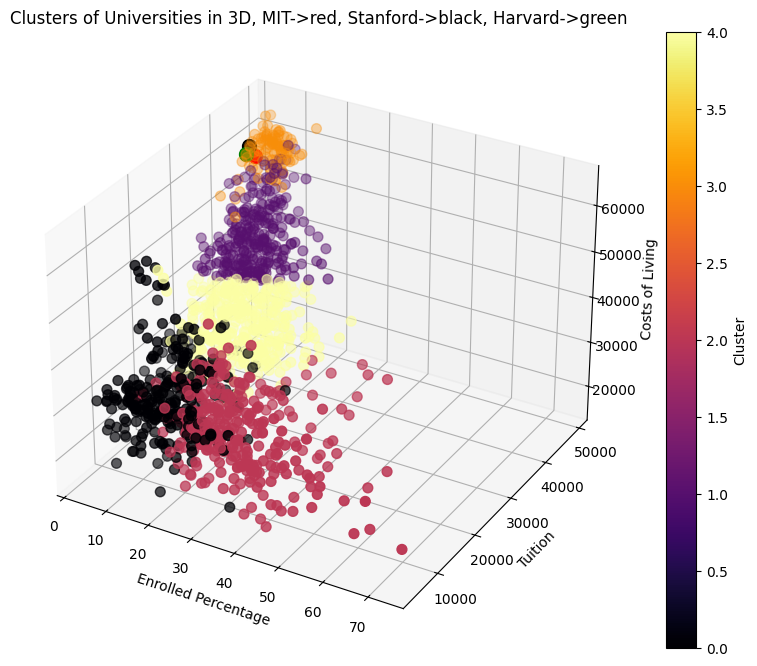

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['Enrolled percentage'],
    df['Tuition and fees'],
    df['Costs of living on campus'],
    c=df['Cluster'],
    cmap='inferno',
    s=50
)

MIT_POINT = ax.scatter(
    MIT['Enrolled percentage'],
    MIT['Tuition and fees'],
    MIT['Costs of living on campus'],
    c="red",
    cmap='inferno',
    s=100
)

STANFORD_POINT = ax.scatter(
    STANFORD['Enrolled percentage'],
    STANFORD['Tuition and fees'],
    STANFORD['Costs of living on campus'],
    c="black",
    cmap='inferno',
    s=100
)

HARVARD_POINT = ax.scatter(
    HARVARD['Enrolled percentage'],
    HARVARD['Tuition and fees'],
    HARVARD['Costs of living on campus'],
    c="green",
    cmap='inferno',
    s=100
)

ax.set_xlabel('Enrolled Percentage')
ax.set_ylabel('Tuition')
ax.set_zlabel('Costs of Living')
ax.set_title('Clusters of Universities in 3D, MIT->red, Stanford->black, Harvard->green')

colorbar = fig.colorbar(scatter, ax=ax)
colorbar.set_label('Cluster')

plt.show()

C:\Users\michu\AppData\Local\Temp\ipykernel_7036\2073974396.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  MIT_POINT = ax.scatter(
C:\Users\michu\AppData\Local\Temp\ipykernel_7036\2073974396.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  STANFORD_POINT = ax.scatter(
C:\Users\michu\AppData\Local\Temp\ipykernel_7036\2073974396.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  HARVARD_POINT = ax.scatter(


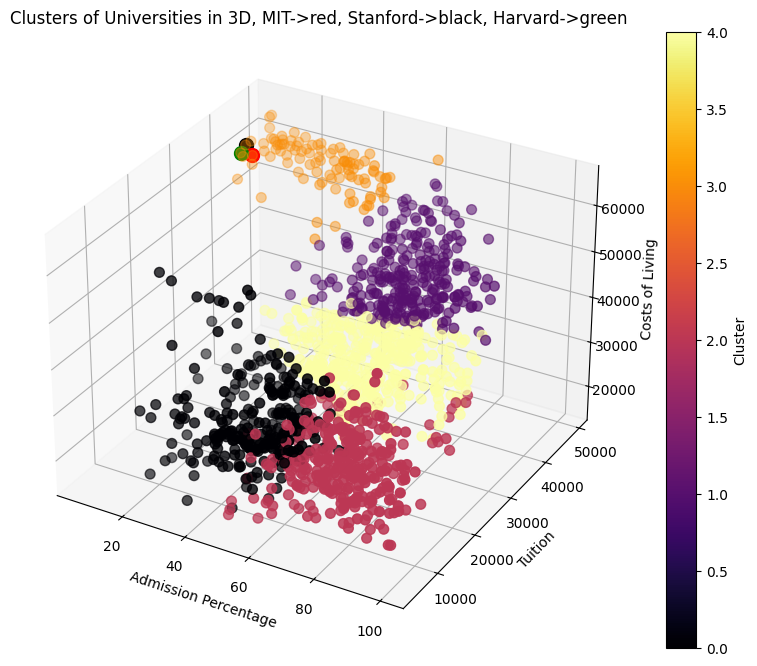

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['Admission percentage'],
    df['Tuition and fees'],
    df['Costs of living on campus'],
    c=df['Cluster'],
    cmap='inferno',
    s=50
)

MIT_POINT = ax.scatter(
    MIT['Admission percentage'],
    MIT['Tuition and fees'],
    MIT['Costs of living on campus'],
    c="red",
    cmap='inferno',
    s=100
)

STANFORD_POINT = ax.scatter(
    STANFORD['Admission percentage'],
    STANFORD['Tuition and fees'],
    STANFORD['Costs of living on campus'],
    c="black",
    cmap='inferno',
    s=100
)

HARVARD_POINT = ax.scatter(
    HARVARD['Admission percentage'],
    HARVARD['Tuition and fees'],
    HARVARD['Costs of living on campus'],
    c="green",
    cmap='inferno',
    s=100
)

ax.set_xlabel('Admission Percentage')
ax.set_ylabel('Tuition')
ax.set_zlabel('Costs of Living')
ax.set_title('Clusters of Universities in 3D, MIT->red, Stanford->black, Harvard->green')

colorbar = fig.colorbar(scatter, ax=ax)
colorbar.set_label('Cluster')

plt.show()

In [ ]:
colors = {0: 'black', 1: 'purple', 2: 'red', 3: 'orange', 4: 'yellow'}
for cluster in sorted(df['Cluster'].unique()):
    rows = df.loc[df['Cluster'] == cluster]
    avg = (sum(rows["Tuition and fees"]) + sum(rows["Costs of living on campus"]))/ len(rows)
    print(f"Average $ to pay for school in cluster {cluster} ({colors[cluster]}) -> {avg}")

Average $ to pay for school in cluster 0 (black) -> 43555.494423791824
Average $ to pay for school in cluster 1 (purple) -> 84249.34057971014
Average $ to pay for school in cluster 2 (red) -> 40070.912052117266
Average $ to pay for school in cluster 3 (orange) -> 104631.8431372549
Average $ to pay for school in cluster 4 (yellow) -> 63342.318559556785


#### Cluster classification based

In [ ]:
X = df.drop(columns=['Name', 'Ranking', 'Ranking display', 'Cluster'])
y = df['Cluster']

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=7)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

Accuracy score: 0.9483282674772037


Text(0.5, 1.0, 'Macierz pomyłek klasyfikacji klastrów')

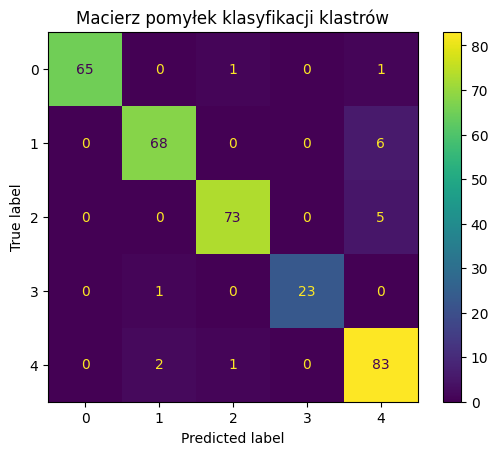

In [ ]:
print(f'Accuracy score: {accuracy}')
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier.classes_)
ax = disp.plot()
ax.ax_.set_title('Macierz pomyłek klasyfikacji klastrów')

#### Cluster classification based on Addmisions [%] and Enrolled [%]

In [ ]:
X = df.drop(columns=['Name', 'Tuition and fees', 'Costs of living on campus', 'Ranking', 'Ranking display', 'Cluster'])
y = df['Cluster']

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=7)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

Accuracy score: 0.5896656534954408


Text(0.5, 1.0, 'Macierz pomyłek klasyfikacji klastrów')

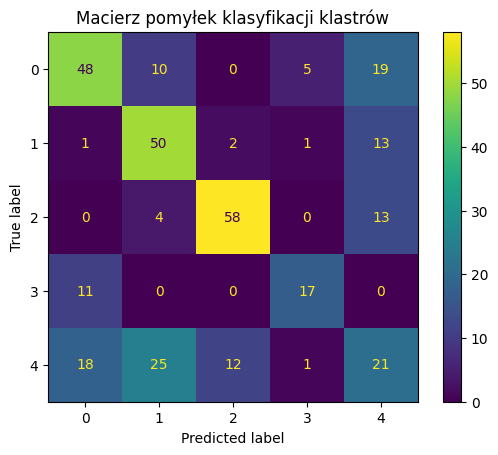

In [ ]:
print(f'Accuracy score: {accuracy}')
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier.classes_)
ax = disp.plot()
ax.ax_.set_title('Macierz pomyłek klasyfikacji klastrów')